In [5]:
import tensorflow as tf
print(tf.__version__)
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools

2.13.0-rc1


## define load image function and load the images


In [9]:
def load_image(image_path):
    max_dimension = 512
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dimension = max(shape)
    scale = max_dimension/long_dimension
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    return image

In [10]:
#load the images
content_image_path = "content_img1.jpeg"
style_image_path = "wave.jpg"

In [11]:
content_image = load_image(content_image_path)
style_image = load_image(style_image_path)
print(content_image.shape, style_image.shape)

(1, 340, 512, 3) (1, 512, 512, 3)


In [12]:
#plotting of images
def plotImage(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

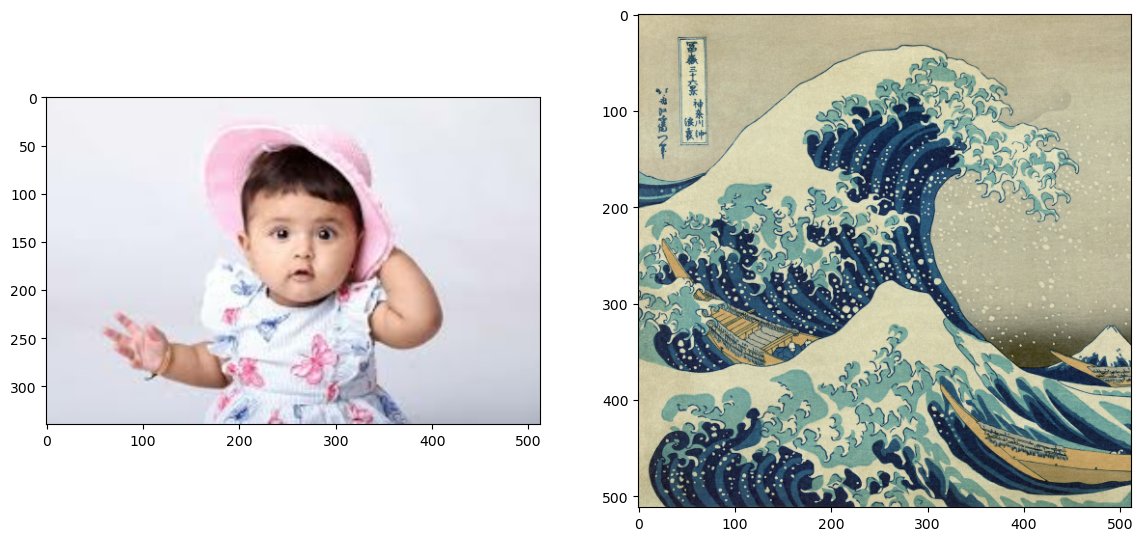

In [13]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plotImage(content_image)
plt.subplot(1,2,2)
plotImage(style_image)

## loading the VGG19 model

In [15]:
z = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
z = tf.image.resize(z, (224, 224))
z.shape

TensorShape([1, 224, 224, 3])

In [32]:
vgg = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top = False)
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
#get the name of every layer of our model
for layer in vgg.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [35]:
content_layer = ["block5_conv2"]

style_layer = ["block1_conv1",
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

num_content_layer = len(content_layer)
num_style_layer = len(style_layer)

## Extracting features from different layers

In [36]:
#function to extract features
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    Model = tf.keras.Model([vgg.input], outputs)
    return Model

In [37]:
styleImage_feature_extractor = vgg_layers(style_layer)
style_image_features_outputs = styleImage_feature_extractor(style_image * 255)

In [38]:
for i in style_image_features_outputs:
    print(i.shape)

(1, 512, 512, 64)
(1, 256, 256, 128)
(1, 128, 128, 256)
(1, 64, 64, 512)
(1, 32, 32, 512)


## Gram matrix (XX^T)

In [39]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("fijc,fijd->fcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_location = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return (result / num_location)

In [44]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layer, content_layer):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layer + content_layer)
        self.style_layer = style_layer
        self.content_layer = content_layer
        self.num_style_layer = len(style_layer)
        self.vgg.trainable = False
    
    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[: self.num_style_layer],
                                        outputs[self.num_style_layer :])
        
        style_outputs = [gram_matrix(style_image_features_outputs) for style_image_features_outputs in style_outputs]
        content_dict = {content_name : value for content_name, value in zip(self.content_layer, content_outputs)}
        style_dict = {style_name : value for style_name, value in zip(self.style_layer, style_outputs)}
        return {"content" : content_dict, "style" : style_dict}

In [45]:
extractor = StyleContentModel(style_layer, content_layer)
result = extractor(tf.constant(content_image))

print("Styles")
for name, output in sorted(result["style"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

Styles
  block1_conv1
shape (1, 64, 64)

  block2_conv1
shape (1, 128, 128)

  block3_conv1
shape (1, 256, 256)

  block4_conv1
shape (1, 512, 512)

  block5_conv1
shape (1, 512, 512)



In [46]:
print("Content")
for name, output in sorted(result["content"].items()):
    print(" ", name)
    print("shape", output.numpy().shape)
    print()

Content
  block5_conv2
shape (1, 21, 32, 512)



In [47]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

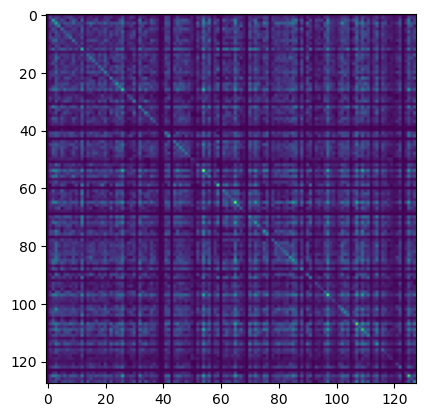

In [48]:
plt.imshow(style_targets["block2_conv1"].numpy()[0])

## Optimization

In [49]:
image = tf.Variable(content_image)

In [50]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [52]:
optimizer = tf.optimizers.legacy.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

In [53]:
style_weight = 1e-2
content_weight = 1e4

In [54]:
def content_style_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) **2)
                          for name in style_outputs.keys()])
    style_loss *= style_weight/num_style_layer
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) **2)
                          for name in content_outputs.keys()])
    content_loss *= content_weight/num_content_layer
    
    loss = style_loss + content_loss
    return loss

In [55]:
@tf.function
def train_steps(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = content_style_loss(outputs)
        gradient = tape.gradient(loss, image)
        optimizer.apply_gradients([(gradient, image)])
        image.assign(clip_0_1(image))

In [56]:
for i in range(4):
    train_steps(image)

In [57]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype= np.uint8)
    if np.ndim(tensor) >3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

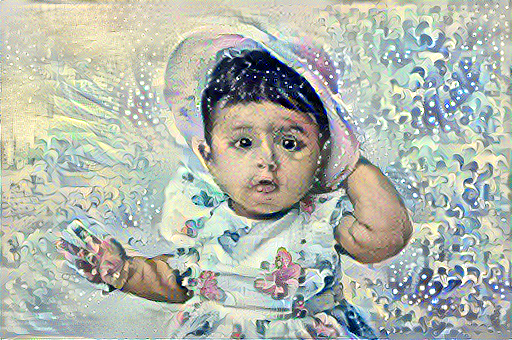

In [58]:
import IPython.display as display
epochs = 10
steps_per_epoch = 100
step = 0

for epoch in range(epochs):
    for steps in range(steps_per_epoch):
        step += 1
        train_steps(image)
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))